### Etivity 2: Exploratory Data Analysis and Data Preparation
#### Student: Christos Koutsiaris

#### Task 1: Data Preparation Pipeline

In [9]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv("bank.csv")
features = df.copy()

# Identify numeric and categorical columns
numeric_cols = features.select_dtypes(include=np.number).columns.tolist()
categorical_cols = features.select_dtypes(exclude=np.number).columns.tolist()

# Create subpipelines
numeric_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_transformer = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),  
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Create the ColumnTransformer
preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Building the main pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor)
])

# Fit/transform to get the final prepared data
prepared_data = pipeline.fit_transform(features)

print("Prepared data shape:", prepared_data.shape)
print("Number of NaNs after pipeline:", np.isnan(prepared_data).sum())


Prepared data shape: (2000, 49)
Number of NaNs after pipeline: 0


#### Task 2: k-Means

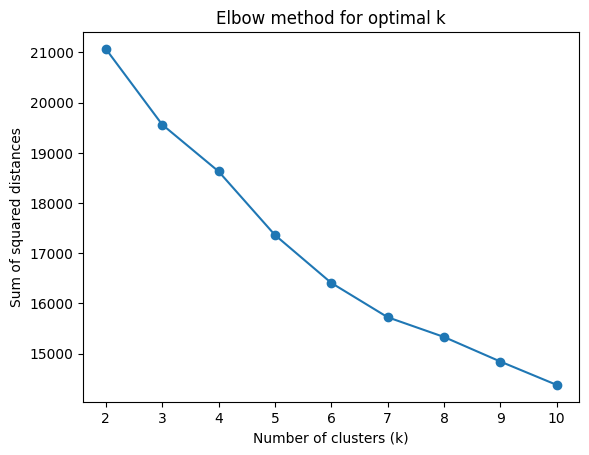

In [13]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = []
K_range = range(2, 11)  # e.g. k=2 to k=10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(prepared_data)
    sse.append(kmeans.inertia_)  # I saw inertia here: https://anakin297.medium.com/kmeans-clustering-with-python-4f7cdfe43d59 

plt.figure()
plt.plot(list(K_range), sse, marker="o")
plt.title("Elbow method for optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Sum of squared distances")
plt.show()


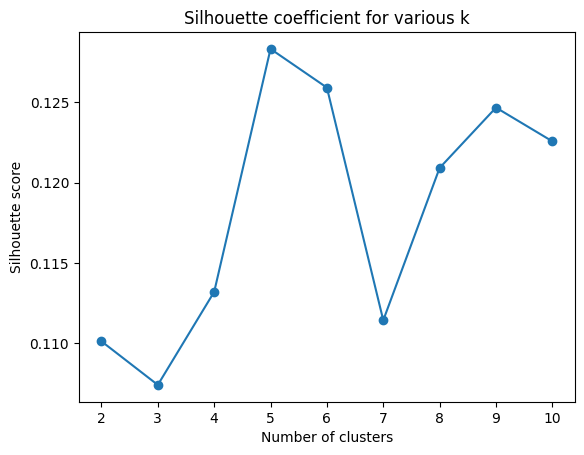

In [15]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(prepared_data)
    sil = silhouette_score(prepared_data, labels) # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
    sil_scores.append(sil)

plt.figure()
plt.plot(list(K_range), sil_scores, marker="o")
plt.title("Silhouette coefficient for various k")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()


In [17]:
# Suppose from the elbow and silhouette, we pick k = best_k
best_k = 4  # for example

kmeans = KMeans(n_clusters=best_k, random_state=42)
cluster_labels = kmeans.fit_predict(prepared_data)

# I attach the cluster labels back to my original df
df['cluster_kmeans'] = cluster_labels
print(df['cluster_kmeans'].value_counts())


cluster_kmeans
1    896
2    677
0    418
3      9
Name: count, dtype: int64


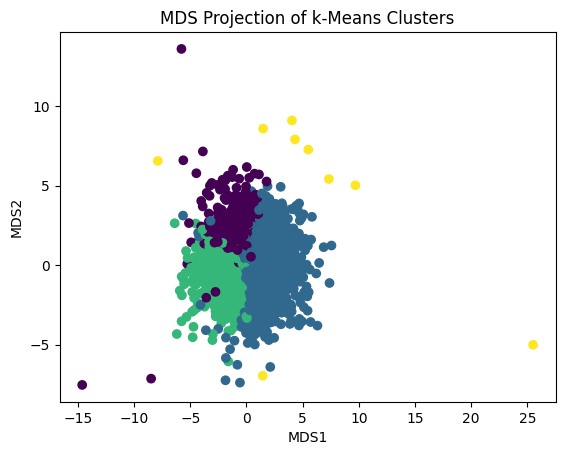

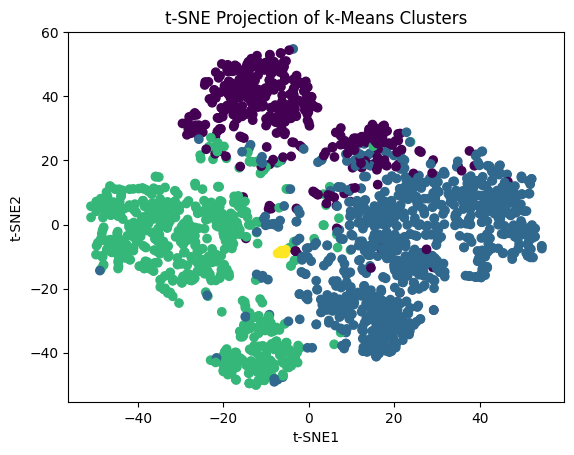

In [14]:
from sklearn.manifold import MDS, TSNE

# --- MDS ---
mds = MDS(n_components=2, random_state=42)
mds_coords = mds.fit_transform(prepared_data)

plt.figure()
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], c=cluster_labels)
plt.title("MDS Projection of k-Means Clusters")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.show()

# --- t-SNE ---
tsne = TSNE(n_components=2, random_state=42)
tsne_coords = tsne.fit_transform(prepared_data.toarray() if hasattr(prepared_data, 'toarray') else prepared_data)

plt.figure()
plt.scatter(tsne_coords[:, 0], tsne_coords[:, 1], c=cluster_labels)
plt.title("t-SNE Projection of k-Means Clusters")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()


In [19]:
from sklearn.cluster import DBSCAN

# DBSCAN parameters requires some tuning:
# - eps (neighborhood radius)
# - min_samples
# https://medium.com/@mohantysandip/a-step-by-step-approach-to-solve-dbscan-algorithms-by-tuning-its-hyper-parameters-93e693a91289
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(prepared_data)

# Number of clusters found by DBSCAN (excluding noise if label = -1)
unique_labels = np.unique(labels_dbscan)
n_clusters = len(unique_labels[unique_labels != -1])
print(f"Estimated number of clusters: {n_clusters}")
print("Cluster labels frequency:")
print(pd.Series(labels_dbscan).value_counts())


Estimated number of clusters: 1
Cluster labels frequency:
-1    1993
 0       7
Name: count, dtype: int64


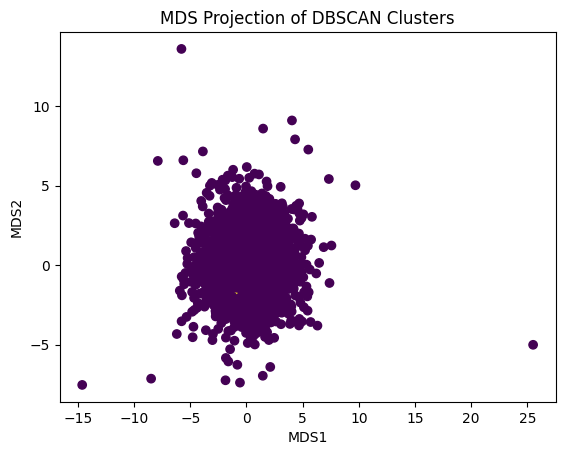

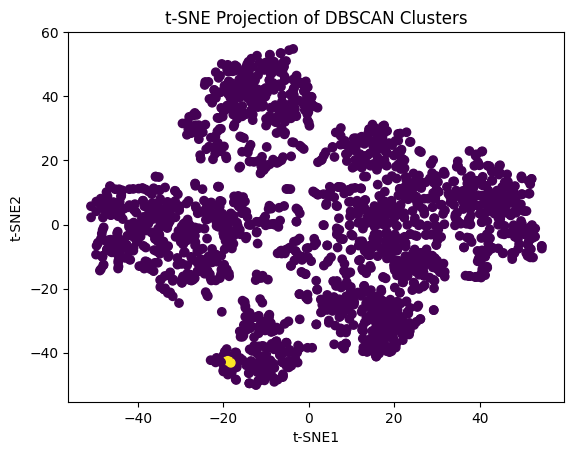

In [18]:
# --- MDS for DBSCAN ---
mds_coords_dbscan = mds.fit_transform(prepared_data)

plt.figure()
plt.scatter(mds_coords_dbscan[:, 0], mds_coords_dbscan[:, 1], c=labels_dbscan)
plt.title("MDS Projection of DBSCAN Clusters")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.show()

# --- t-SNE for DBSCAN ---
tsne_coords_dbscan = tsne.fit_transform(prepared_data.toarray() if hasattr(prepared_data, 'toarray') else prepared_data)

plt.figure()
plt.scatter(tsne_coords_dbscan[:, 0], tsne_coords_dbscan[:, 1], c=labels_dbscan)
plt.title("t-SNE Projection of DBSCAN clusters")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()
